In [1]:
import folium
import pandas as pd
from folium import Choropleth, Circle, Marker, Icon, GeoJson
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd

In [2]:
tehran_eq = pd.read_csv('Earthquake_Qazvin.txt', sep='\t')[1:]
qazvin_eq = pd.read_csv('Earthquake_Tehran.txt', sep='\t')[1:]
eq = pd.concat([tehran_eq, qazvin_eq]).drop_duplicates().dropna()
eq = eq.astype({
    'Latitude': 'float',
    'Longitude': 'float',
    'Magnitude': 'float',
    'Depth': 'float'
    })
eq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 1 to 46
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE-TIME  55 non-null     object 
 1   Latitude   55 non-null     float64
 2   Longitude  55 non-null     float64
 3   Depth      55 non-null     float64
 4   Magnitude  55 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.6+ KB


In [3]:
stations = pd.read_html('http://irsc.ut.ac.ir/english_txt/Sub%20Network.htm', header=0)[0]
stations = stations[~(stations['SubNetwork'] == 'Inactive  Stations')].dropna()

In [4]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 0 to 112
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No               113 non-null    float64
 1   SubNetwork       113 non-null    object 
 2   Station Code     113 non-null    object 
 3   Station Name     113 non-null    object 
 4   Latitude  (N˚)   113 non-null    float64
 5   Longitude  (E˚)  113 non-null    float64
 6   Altitude (m)     113 non-null    float64
dtypes: float64(4), object(3)
memory usage: 7.1+ KB


In [5]:
location = [eq.Latitude.mean(), eq.Longitude.mean()]

In [6]:
map1 = folium.Map(location=location, tiles='Stamen Terrain', zoom_start=6)
for idx, row in eq.iterrows():
    Marker([row['Latitude'], row['Longitude']], icon=Icon(color='blue'), popup=row['DATE-TIME']).add_to(map1)

for idx, row in stations.iterrows():
    Marker([row['Latitude  (N˚)'], row['Longitude  (E˚)']], icon=Icon(color='red'), popup=row['Station Name']).add_to(map1)

map1

In [7]:
eq_gdf = gpd.GeoDataFrame(eq, geometry=gpd.points_from_xy(eq.Longitude, eq.Latitude))
eq_gdf.crs = {'init': 'epsg:4326'}
eq_gdf.head()

/home/gazelle98/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,DATE-TIME,Latitude,Longitude,Depth,Magnitude,geometry
1,2020-06-02_12:05:04,36.589,50.226,8.0,2.8,POINT (50.22600 36.58900)
2,2020-06-02_09:15:51,35.784,52.045,12.1,2.9,POINT (52.04500 35.78400)
3,2020-06-01_22:50:10,36.694,49.788,14.9,2.9,POINT (49.78800 36.69400)
4,2020-06-01_14:21:16,35.785,52.013,10.6,2.6,POINT (52.01300 35.78500)
5,2020-05-31_01:38:48,36.417,51.320,15.4,3.0,POINT (51.32000 36.41700)


In [8]:
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations['Longitude  (E˚)'], stations['Latitude  (N˚)']))
stations_gdf.crs = {'init': 'epsg:4326'}
stations_gdf.describe()

/home/gazelle98/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,No,Latitude (N˚),Longitude (E˚),Altitude (m)
count,113.000000,113.000000,113.000000,113.000000
mean,63.203540,33.947060,52.813424,1732.079646
std,36.670141,2.947925,4.262592,704.242705
min,1.000000,25.867100,45.619000,18.000000
25%,31.000000,32.117000,49.287000,1319.000000
50%,63.000000,34.470000,52.241000,1940.000000
75%,95.000000,36.290000,56.686000,2273.000000
max,125.000000,38.713000,60.349000,2850.000000


In [9]:
map3 = folium.Map(location=location, tiles='Stamen Terrain', zoom_start=6)

for idx, row in eq.iterrows():
    record = eq_gdf.iloc[idx-1]
    distances = stations_gdf.geometry.distance(record.geometry)
    nearest = stations_gdf.iloc[distances.idxmin()]
    folium.Marker(location=[row['Latitude'], row['Longitude']], icon=folium.Icon(color='red')).add_to(map3)
    folium.Marker(location=[nearest.get('Latitude  (N˚)'), nearest.get('Longitude  (E˚)')], icon=folium.Icon(color='blue')).add_to(map3)

    folium.PolyLine(
        locations=[[nearest.get('Latitude  (N˚)'), nearest.get('Longitude  (E˚)')], [row['Latitude'], row['Longitude']]],
        color='green'
    ).add_to(map3)
map3

## Part 2

In [10]:
map2 = folium.Map(location=location, titles='OpenStreetMap', zoom_start=7)
for idx, row in eq.iterrows():
    mag = row['Magnitude'] *10000
    folium.Circle(location=[row['Latitude'], row['Longitude']], color='red', radius=mag, weight=1).add_to(map2)
HeatMap(data=eq[['Latitude', 'Longitude', 'Depth']], radius=65).add_to(map2)
map2

## Part 3

In [11]:
tehran_eq = tehran_eq.drop_duplicates().dropna()
tehran_eq = tehran_eq.astype({
    'Latitude': 'float',
    'Longitude': 'float',
    'Magnitude': 'float',
    'Depth': 'float'
    })

In [12]:
tehran_eq_gdf = gpd.GeoDataFrame(tehran_eq, geometry=gpd.points_from_xy(tehran_eq.Longitude, tehran_eq.Latitude))
tehran_eq_gdf.crs = {'init': 'epsg:4326'}
tehran_eq_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 41 entries, 1 to 41
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   DATE-TIME  41 non-null     object  
 1   Latitude   41 non-null     float64 
 2   Longitude  41 non-null     float64 
 3   Depth      41 non-null     float64 
 4   Magnitude  41 non-null     float64 
 5   geometry   41 non-null     geometry
dtypes: float64(4), geometry(1), object(1)
memory usage: 2.2+ KB


/home/gazelle98/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [13]:
teh_distances = []
for idx, row in tehran_eq.iterrows():
    record = tehran_eq_gdf.iloc[idx-1]
    distances = stations_gdf.geometry.distance(record.geometry)
    nearest = stations_gdf.iloc[distances.idxmin()]
    eq_loc = [row['Latitude'], row['Longitude']]
    station_loc = [nearest.get('Latitude  (N˚)'), nearest.get('Longitude  (E˚)')]
    teh_distances.append((distances.min(), eq_loc, station_loc))

In [14]:
point = max(teh_distances, key=lambda x:x[0])
point

(0.6464973819745933, [36.843, 52.074], [36.43975, 51.56868])

In [15]:
map4 = folium.Map(location=location, tiles='Stamen Terrain', zoom_start=8)

folium.Marker(location=point[1], icon=folium.Icon(color='red')).add_to(map4)

# I think there is no need to show the station place
# folium.Marker(location=point[2], icon=folium.Icon(color='blue')).add_to(map4)
map4

## Part 4

In [16]:
# d/r is the formula to calculate the distance in radian
# The radius of earth is 6,371 km.
buffer = stations_gdf.geometry.buffer((50/6371)*57.2958)
buffer.head()

0    POLYGON ((50.70266 30.60000, 50.70050 30.55593...
1    POLYGON ((49.09366 31.33000, 49.09150 31.28593...
2    POLYGON ((49.73666 31.66500, 49.73450 31.62093...
3    POLYGON ((59.46466 33.42500, 59.46250 33.38093...
4    POLYGON ((60.31766 32.73900, 60.31550 32.69493...
dtype: geometry

In [17]:
map5 = folium.Map(location=location, tiles='CartoDB dark_matter', zoom_start=5)
for idx, row in stations_gdf.iterrows():
    Marker([row['Latitude  (N˚)'], row['Longitude  (E˚)']]).add_to(map5)
GeoJson(buffer.to_crs(epsg=4326)).add_to(map5)
map5

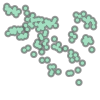

In [18]:
union = buffer.geometry.unary_union
union

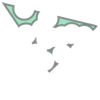

In [19]:
missed_eqs = tehran_eq_gdf[tehran_eq_gdf['geometry'].within(union) == False]
conhull = missed_eqs.geometry.to_crs(epsg=4326).unary_union.convex_hull
conhull.difference(union)